# [COM6513] Assignment: Topic Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for topic classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**2 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**3 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**1 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500} and the dropout rate {e.g. 0.2, 0.5}. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**2 marks**). 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**1 mark**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**1 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**3 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices. You must provide detailed explanations of your implementation, provide a detailed analysis of the results (e.g. why a model performs better than other models etc.) including error analyses (e.g. examples and discussion/analysis of missclasifications etc.)  (**10 marks**). 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in Lab 1 (**2 marks**). 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

Class 1: Politics, Class 2: Sports, Class 3: Economy

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You **must** submit a Jupyter Notebook file (assignment_yourusername.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`, you need to have a Latex distribution installed e.g. MikTex or MacTex and pandoc). If you are unable to export the pdf via Latex, you can print the notebook web page to a pdf file from your browser (e.g. on Firefox: File->Print->Save to PDF).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/3/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results and discussion is as important as the implementation and accuracy of your models. Please be brief and consice in your discussion and analyses. 

This assignment will be marked out of 30. It is worth 30\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 26 Apr 2023** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
#Read Training Data and store it in a dataframe 
train_df = pd.read_csv('/Users/abolivi/Masters_Doc_Sem2/NLP_Lab/assignment/data_topic/train.csv',
                       names = ['Class','News_Articles'])
x_raw = train_df['News_Articles']

In [3]:
#Read Development Data and store it in a dataframe 
dev_df = pd.read_csv('/Users/abolivi/Masters_Doc_Sem2/NLP_Lab/assignment/data_topic/dev.csv',
                     names = ['Class','News_Articles'])


In [4]:
#Read Test Data and store it in a dataframe 
test_df = pd.read_csv('/Users/abolivi/Masters_Doc_Sem2/NLP_Lab/assignment/data_topic/test.csv',
                      names = ['Class','News_Articles'])


# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [5]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [6]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
               stop_words=[], vocab=set()):
# Uses re pattern to extract matching substrings from a given string, and 
# returns a list of those substrings
    tokens = re.findall(token_pattern, x_raw.lower())

# Removes the stop words
    tokens = [token for token in tokens if token not in stop_words]

# Creates ngrams using a loop and store them in the the list
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):
        for i in range(len(tokens)-n+1):
            ngram = ' '.join(tokens[i:i+n])
            if not vocab or ngram in vocab:
                ngrams.append(ngram)


    return ngrams

In [7]:
ngrams = extract_ngrams(x_raw[0],ngram_range=(1,1),stop_words=stop_words)
print(ngrams)

['reuters', 'venezuelans', 'turned', 'out', 'early', 'large', 'numbers', 'sunday', 'vote', 'historic', 'referendum', 'either', 'remove', 'left', 'wing', 'president', 'hugo', 'chavez', 'office', 'give', 'him', 'new', 'mandate', 'govern', 'next', 'two', 'years']


### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [8]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    # Initialized an empty dictionary which will be used to store document frequency of n-grams
    df = {}
    vocab=set()
    ngram_counts=0
    #vocab returns all the unique ngrams and df contains document freq of each n-grams across all the articles
    for article in X_raw:
        ngrams=extract_ngrams(article,ngram_range, token_pattern, stop_words)
        ngrams=set(ngrams)
        for ngram in ngrams:
            vocab.add(ngram)
            if ngram in df:
                df[ngram]+=1
            else:
                df[ngram]=1
                
    #sorts the dictionary by its values in descending order, which keeps the items with a value greater than min_df
    df = {k:v for k,v in sorted(df.items(), key=lambda item: item[1], reverse= True) if v > min_df}
    #Checks if keep_topN is true and keeps only top keep_topN items from the df dictionary
    if keep_topN:
        df= dict(list(df.items())[:keep_topN])
    
    #removes any n-grams from a list vocab that are not present in a dictionary df. 
    vocab_copy=list(vocab)
    for ngram in vocab_copy:
        if ngram not in df:
            vocab.remove(ngram)
            
            
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [42]:
vocab, df, ngram_counts = get_vocab(x_raw,(1,1),r'\b[A-Za-z][A-Za-z]+\b', 2, 2000, stop_words)
print("Vocab: \n", list(vocab)[:30])
print("\n Document Frequency \n", df)
len(vocab)


Vocab: 
 ['players', 'collect', 'yasser', 'sardinia', 'returning', 'months', 'rangers', 'lows', 'tests', 'strength', 'already', 'seen', 'sweep', 'missed', 'since', 'hopes', 'target', 'insurers', 'facilities', 'case', 'cost', 'gerhard', 'massacre', 'march', 'yet', 'teammates', 'kobe', 'playing', 'first', 'bush']

 Document Frequency 
 {'reuters': 631, 'said': 432, 'tuesday': 413, 'wednesday': 344, 'new': 325, 'after': 295, 'ap': 275, 'athens': 245, 'monday': 221, 'first': 210, 'two': 187, 'york': 187, 'over': 186, 'us': 184, 'olympic': 183, 'inc': 169, 'more': 157, 'year': 151, 'oil': 150, 'prices': 149, 'company': 147, 'world': 146, 'than': 140, 'aug': 140, 'about': 133, 'had': 133, 'one': 133, 'united': 133, 'sunday': 130, 'out': 130, 'into': 126, 'against': 124, 'up': 124, 'second': 119, 'last': 117, 'president': 111, 'stocks': 111, 'gold': 110, 'team': 109, 'when': 106, 'three': 105, 'night': 105, 'time': 104, 'yesterday': 104, 'games': 104, 'olympics': 102, 'states': 101, 'greece':

2000

Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [43]:
''' Created two dictionaries id_to_word and word_to_id
    id_to_word dictionary stores id as key and words as value
    word_to_id dictionary stores words as key and id as value'''
def create_Dictionary(vocab):
    id_to_word={}
    word_to_id={}
    for i,v in enumerate(vocab):
        id_to_word[i]=v
        word_to_id[v]=i
        
    return id_to_word, word_to_id

In [44]:
id_to_word,word_to_id=create_Dictionary(vocab)

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [45]:
# Extracting News_Articles column from the dataframe for train, test, dev datasets and converting them to a list
train_df_list = train_df['News_Articles'].tolist()
dev_df_list = dev_df['News_Articles'].tolist()
test_df_list = test_df['News_Articles'].tolist()
vocab_train, df_train, ngram_counts_train = get_vocab(train_df_list,(1,1),r'\b[A-Za-z][A-Za-z]+\b', 1, 2000, stop_words)
len(vocab_train)

2000

In [46]:
#train_df_list=['My city is reuters','My name is not president']
#Initialized 3 empty lists to store resulting ngrams for each document
train_docs_ngrams=[]
dev_docs_ngrams=[]
test_docs_ngrams=[]
''' Extract all unigrams within the document, removing the given stop words and storing them in the lists
    This is done for train, development and test datasets.'''
for train_doc in train_df_list:
    train_doc_ngrams=extract_ngrams(train_doc,ngram_range=(1,1),stop_words=stop_words)
    train_docs_ngrams.append(train_doc_ngrams)
for dev_doc in dev_df_list:
    dev_doc_ngrams=extract_ngrams(dev_doc,ngram_range=(1,1),stop_words=stop_words)
    dev_docs_ngrams.append(dev_doc_ngrams)
for test_doc in test_df_list:
    test_doc_ngrams=extract_ngrams(test_doc,ngram_range=(1,1),stop_words=stop_words)
    test_docs_ngrams.append(test_doc_ngrams)

Then convert them into lists of indices in the vocabulary:

In [47]:
''' Converts the extracted n-grams for each document in the train, dev, 
    and test sets to their corresponding IDs. The resulting IDs for each 
    document are then stored as numpy arrays in three separate lists:
    train_articles_ids, dev_articles_ids, and test_articles_ids'''
train_articles_ids=[]
dev_articles_ids=[]
test_articles_ids=[]
for article_ngrams_tr in train_docs_ngrams:
    article_ids=[]
    for ngram in article_ngrams_tr:
        if ngram in word_to_id:
            article_ids.append(word_to_id[ngram])
    train_articles_ids.append(np.array(article_ids,dtype=np.int32))


for article_ngrams_dv in dev_docs_ngrams:
    article_ids=[]
    for ngram in article_ngrams_dv:
        if ngram in word_to_id:
            article_ids.append(word_to_id[ngram])
    dev_articles_ids.append(np.array(article_ids,dtype=np.int32))

for article_ngrams_tst in test_docs_ngrams:
    article_ids=[]
    for ngram in article_ngrams_tst:
        if ngram in word_to_id:
            article_ids.append(word_to_id[ngram])
    test_articles_ids.append(np.array(article_ids,dtype=np.int32))

#print(train_articles_ids)---- output-[[81, 7200, 3771], [81, 923, 4406]]

In [48]:
train_articles_ids

[array([ 616,  800,  933,  255,  231, 1290,  569,  834, 1781, 1030, 1976,
        1278,  413,  621, 1136,  622,  402, 1718, 1033, 1886, 1412,  281,
         812, 1630,  342], dtype=int32),
 array([ 616,  246,  709,  312, 1943,  867,  354,  834,  580, 1831,  553,
        1928,   96, 1578,  936, 1774, 1301], dtype=int32),
 array([ 616,  268, 1455,  187,  731,  394, 1666,  153, 1304,  749,  834,
         137,  445,  330, 1614, 1017, 1264, 1840], dtype=int32),
 array([1173, 1049, 1189,  529,  203,  332,  246,  328, 1711, 1705,   60,
         203], dtype=int32),
 array([1197, 1232, 1851, 1679,   76,  669,  961, 1259, 1198,  332,  834,
          28, 1467, 1794,  163,  158,   14,  383, 1699,  394,  788, 1503,
        1810,  286,  268], dtype=int32),
 array([ 616, 1851, 1774,  834,  961, 1198,   28, 1467,  163,  150,  559,
         952,  139, 1010, 1442,  553,  940, 1259, 1131,  332], dtype=int32),
 array([1197,  798, 1003, 1323, 1555,  685,   36, 1434, 1324,  834,  286,
         580, 1200,  9

Put the labels `Y` for train, dev and test sets into arrays: 

In [49]:
'''Extracts values from dataframe column 'Class' in train_df, dev_df, 
   test_df and converts them into a numpy array. The class labels are integers starting 
   from 1. The -1 operation subtracts 1 from each class label that converts
   them to a zero-indexed array'''
train_label = np.array(train_df['Class'])
train_label= train_label-1
dev_label = np.array(dev_df['Class'])
dev_label=dev_label-1
test_label = np.array(test_df['Class'])
test_label=test_label-1
train_label

array([0, 0, 0, ..., 2, 2, 2])

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [50]:
'''This function returns the dictionary of randomly initialized weights 
   for a neural network with an input layer, one or more hidden layers, and an output layer. 
   The I/P layer 'vocab_size' represents the number of unique words 
   or ngrams in the vocabulary. The O/P layer 'num_classes' represents the number of classes which will be classified 
   by a neural network. If hidden_dim is an empty list, the neural network will only have an i/p layer and an o/p layer.'''
def network_weights(vocab_size=2000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.1):
    layers_dim=[vocab_size]+[embedding_dim]+hidden_dim+[num_classes]
    W={}
    for input_layer in range(len(layers_dim)-1):
        W[input_layer]= np.random.uniform(-init_val, init_val, (layers_dim[input_layer],layers_dim[input_layer+1])).astype(np.float32)

    return W
    

In [51]:
W = network_weights(vocab_size=2000,embedding_dim=300,hidden_dim=[], num_classes=3)
W


{0: array([[-0.02637493, -0.09433637, -0.06779089, ..., -0.02193159,
         -0.09183982, -0.08483312],
        [-0.01634685,  0.01913789,  0.09112325, ..., -0.07781994,
         -0.01977547,  0.08452381],
        [ 0.04183768,  0.0679256 ,  0.07946683, ..., -0.05193486,
          0.01428006, -0.03478409],
        ...,
        [-0.00028373,  0.03143086,  0.0131515 , ...,  0.01424241,
          0.06348188,  0.00103876],
        [-0.08830725,  0.01619583, -0.08653948, ..., -0.00863065,
          0.06186633,  0.09729445],
        [ 0.01061703, -0.02167895,  0.09023168, ...,  0.04236311,
          0.01756194, -0.06356017]], dtype=float32),
 1: array([[ 1.34228431e-02,  9.28744152e-02, -3.62130105e-02],
        [-2.29819063e-02, -6.07093684e-02, -1.72710381e-02],
        [-5.30987605e-02,  7.23892003e-02, -5.91134429e-02],
        [ 9.31851193e-02,  9.32889357e-02, -4.41807285e-02],
        [-5.05105741e-02, -4.53830976e-03, -7.49312043e-02],
        [-8.45093355e-02,  4.45363373e-02,  2.6

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [52]:
'''Softmax fn takes a numpy array z which represents the output of the last layer of a neural network, and returns 
   the softmax of z. Softmax is a commonly used activation function in the output layer of multi-class classification.
   sig returns the probabilities of each class'''
def softmax(z):
    Numerator = np.exp(z)
    Denominator = np.sum(np.exp(z))
    sig = Numerator / Denominator   
    return sig

In [53]:
sig= softmax([5,6,7])
sig

array([0.09003057, 0.24472847, 0.66524096])

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [54]:
'''This function computes the cross-entropy loss for a single sample by comparing the predicted probabilities (y_preds) 
   with the true label (y).'''
def categorical_loss(y, y_preds):
    l=-np.log(y_preds[y])
    return l

In [55]:
l=categorical_loss(1,[0.3,0.6,0.1])
l

0.5108256237659907

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [56]:
''' This function takes numpy array z as input and applies relu function to it element-wise'''
def relu(z):
    z = z.copy()
    a = np.maximum(0, z)    
    return a
    ''' This function computes the derivative of relu activation fn given an i/p 'z'. Returns an array of same shape as z 
    where the elements are 0 if the corresponding element in z is negative or 0 and 1 if it is positive.'''
def relu_derivative(z):
    dz=np.array(z)
    dz = dz.copy()
    dz[dz <= 0] = 0
    dz[dz > 0] = 1  
    return dz

In [57]:
dz= relu_derivative([1,-2,0])
dz

array([1, 0, 0])

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [58]:
''' Returns a vector of the same size as the input size with values either 1 or 0. The probability of a value 
    being 0 is determined by the dropout_rate input.'''
def dropout_mask(size, dropout_rate): 
    '''Initialized the dropout_vec as a vector of ones with the same size as 'size' '''    
    dropout_vec = np.ones(size)
    dropout_vec[:round(size*dropout_rate)] = 0.0
    ''' Randomly shuffles the order of the elements in the mask vector and returns the resulting vector.'''    
    np.random.shuffle(dropout_vec)
    return dropout_vec

In [59]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 0. 1. 1. 1. 1. 1. 0. 1.]
[0. 1. 0. 1. 1. 1. 1. 1. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [60]:
def forward_pass(x, W, dropout_rate=0.2):
    '''Initializing empty lists to store the outputs for each layer'''
    out_vals = {}
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    
    # Input layer
    ''' Computes the output by taking the mean of the corresponding rows of W[0](i.e. for each word in input x)'''
    h = np.mean(W[0][x,:],axis=0)
    h_vecs.append(h)
    ''' Apply ReLU activation to the input layer'''
    a = relu(h)
    a_vecs.append(a)
    ''' Create a dropout mask vector''' 
    dropout = dropout_mask(a.shape[0],dropout_rate)
    dropout_vecs.append(dropout)
    ''' Applyting dropout to the input layer'''
    a= a*dropout
    
    layer=0
    # Hidden layers
    for i in range(1,len(W)-1):
        layer=layer+1
        ''' Computes the dot product between a of previous layer and the weight matrix of current layer'''
        h = np.dot(a, W[i])
        h_vecs.append(h)
        ''' Applying ReLU activation'''
        a = relu(h)  
        a_vecs.append(a)
        ''' Create a dropout mask vector for current layer'''
        dropout = dropout_mask(a.shape[0],dropout_rate)
        ''' Applying dropout'''
        a = a * dropout
        dropout_vecs.append(dropout)
    
    # Output layer
    ''' Computes the dot product between a of previous layer and the weight matrix of output layer'''
    h = np.dot(a, W[layer+1])
    h_vecs.append(h)
    ''' Apply softmax function to the output layer to obtain predicted probabilities'''
    probs = softmax(h)
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout'] = dropout_vecs
    out_vals['pred'] = probs
    
    ''' This will return a dictionary of output values for each layer'''
    return out_vals 
    

In [61]:
out_vals=forward_pass([0,0,0,1,1],W , dropout_rate=0.2)
out_vals

{'h': [array([-0.0223637 , -0.04894667, -0.00422523,  0.04108326,  0.04111568,
         -0.08519527, -0.01621249, -0.01957027, -0.00877306, -0.02863121,
         -0.03802076, -0.03569879,  0.00385366, -0.02166606,  0.01365391,
         -0.01951261,  0.01780181, -0.04224939,  0.03091075,  0.03924821,
         -0.06660871,  0.0611973 ,  0.00661314, -0.00837829,  0.03067666,
          0.00637556,  0.05237712,  0.04689235, -0.029748  , -0.01662533,
          0.04356892, -0.05999134,  0.0649419 , -0.04722518,  0.00531162,
         -0.04572587, -0.0245885 ,  0.01480933, -0.01493692, -0.02855929,
          0.00625965, -0.04368814,  0.05423101, -0.06132715, -0.00591042,
          0.06726888,  0.01382804,  0.0500506 , -0.03482917, -0.0386178 ,
          0.09320569,  0.0244156 ,  0.001651  , -0.02699426, -0.06154031,
         -0.02276647, -0.08975885, -0.05054047,  0.01461044,  0.00742705,
         -0.00538513, -0.05102628,  0.03336635, -0.02433196,  0.0137298 ,
          0.01951248,  0.00478553

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [62]:
''' This function updates the weights of a neural network to minimize the loss function'''
def backward_pass(x, y, W, out_vals, lr=0.01, freeze_emb=False):
    
    # Initialize gradients
    '''Initializes a list of numpy arrays with the same shape as the weight matrices W. 
       The list grad will be used to store the gradients of the loss function w.r.t the weights during backpropagation'''
    grad = [np.zeros_like(w) for w in W]
    
    ''' Compute error at output layer by subtracting 1 from the predicted prob of the correct class'''
    output_error = out_vals['pred']
    output_error[y] = output_error[y] - 1
    
    # Backpropagating error through output layer of a neural network
    ''' The grad variable is a list that stores the gradients of the weights for each layer in the network. Here grad[-1]
    corresponds to the output layer'''
    grad[-1] = np.outer(out_vals['a'][-1], output_error)
    delta = output_error
    # Backpropagating error through hidden layers of a neural network
    for i in range(len(W) - 2, 0, -1):
        dropout = out_vals['dropout'][i]
        delta = np.dot(W[i+1], delta) * relu_derivative(out_vals['h'][i])
        delta = delta * dropout
        # Compute gradients for current layer
        grad[i] = np.outer(out_vals['a'][i], delta)
    
    # Backpropagating error through input layer of a neural network
    delta = np.dot(W[1], delta) * relu_derivative(out_vals['h'][0])
    grad[0] = np.zeros_like(W[0])
    for i in x:
        grad[0][i,:] = grad[0][i,:] + delta
    ''' If true, the gradients for the embedding layer are set to zero. '''
    if freeze_emb== True:
        grad[0] = np.zeros_like(W[0])
    
    '''Updates weights using the computed gradients'''
    for i in range(len(W)):
        W[i] = W[i] - (lr * grad[i])
    return W


In [63]:
backward_pass([0,0,0,1,1], 1, W, out_vals, lr=0.001, freeze_emb=False)

{0: array([[-0.02637493, -0.09433637, -0.06779089, ..., -0.02193159,
         -0.09183982, -0.08483312],
        [-0.01634685,  0.01913789,  0.09112325, ..., -0.07781994,
         -0.01977547,  0.08452381],
        [ 0.04183768,  0.0679256 ,  0.07946683, ..., -0.05193486,
          0.01428006, -0.03478409],
        ...,
        [-0.00028373,  0.03143086,  0.0131515 , ...,  0.01424241,
          0.06348188,  0.00103876],
        [-0.08830725,  0.01619583, -0.08653948, ..., -0.00863065,
          0.06186633,  0.09729445],
        [ 0.01061703, -0.02167895,  0.09023168, ...,  0.04236311,
          0.01756194, -0.06356017]], dtype=float32),
 1: array([[ 1.34228431e-02,  9.28744152e-02, -3.62130105e-02],
        [-2.29819063e-02, -6.07093684e-02, -1.72710381e-02],
        [-5.30987605e-02,  7.23892003e-02, -5.91134429e-02],
        [ 9.31716116e-02,  9.33160287e-02, -4.41943138e-02],
        [-5.05240925e-02, -4.51119537e-03, -7.49448004e-02],
        [-8.45093355e-02,  4.45363373e-02,  2.6

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [64]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    
    training_loss_history = []
    validation_loss_history = []
    ''' Initially set to infinity. Later, it will be used to track the previous validation loss'''
    prev_val_loss = float("inf")
    best_weights = None
    
    for epoch in range(epochs):
        '''iterates over each example in the training dataset'''
        for i in range(len(X_tr)):
            x = X_tr[i]
            y = Y_tr[i]
            
            # Forward pass
            out_vals = forward_pass(x, W, dropout_rate=dropout)
            
            ''' Compute loss and gradients using backward pass'''
            W = backward_pass(x, y, W, out_vals, lr=lr, freeze_emb=freeze_emb)
        
                
        '''Compute and store training loss'''
        tr_loss = 0
        for i in range(len(X_tr)):
            x = X_tr[i]
            y = Y_tr[i]
            out_vals = forward_pass(x, W, dropout_rate=0)
            tr_loss = tr_loss + categorical_loss(y, out_vals['pred'])
        tr_loss = tr_loss / len(X_tr)
        training_loss_history.append(tr_loss)
        
        '''Compute and store validation loss'''
        val_loss = 0
        for i in range(len(X_dev)):
            x = X_dev[i]
            y = Y_dev[i]
        
            out_vals = forward_pass(x, W, dropout_rate=0)
            val_loss =  val_loss +categorical_loss(y, out_vals['pred'])
        val_loss = val_loss / len(X_dev)
        validation_loss_history.append(val_loss)
        
        '''Checking if validation loss has increased'''
        
        if val_loss < prev_val_loss:
            prev_val_loss = val_loss
            best_weights = W
            '''If true, model's performance is not improving significantly and it will break'''
        elif val_loss >= prev_val_loss + tolerance:
            break
            
        # Print progress
        if print_progress:
            print(f"Epoch {epoch+1}: train loss {tr_loss:.4f}, val loss {val_loss:.4f}") 
    
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [66]:
X_tr=train_articles_ids
Y_tr=train_label
X_dev=dev_articles_ids
Y_dev=dev_label
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.01,
                            epochs=100)


Shape W0 (2000, 300)
Shape W1 (300, 3)
Epoch 1: train loss 1.0938, val loss 1.0963
Epoch 2: train loss 1.0894, val loss 1.0936
Epoch 3: train loss 1.0847, val loss 1.0906
Epoch 4: train loss 1.0794, val loss 1.0873
Epoch 5: train loss 1.0733, val loss 1.0835
Epoch 6: train loss 1.0662, val loss 1.0791
Epoch 7: train loss 1.0580, val loss 1.0739
Epoch 8: train loss 1.0482, val loss 1.0678
Epoch 9: train loss 1.0367, val loss 1.0606
Epoch 10: train loss 1.0233, val loss 1.0520
Epoch 11: train loss 1.0076, val loss 1.0420
Epoch 12: train loss 0.9895, val loss 1.0302
Epoch 13: train loss 0.9688, val loss 1.0166
Epoch 14: train loss 0.9457, val loss 1.0010
Epoch 15: train loss 0.9201, val loss 0.9832
Epoch 16: train loss 0.8925, val loss 0.9634
Epoch 17: train loss 0.8631, val loss 0.9416
Epoch 18: train loss 0.8325, val loss 0.9179
Epoch 19: train loss 0.8012, val loss 0.8925
Epoch 20: train loss 0.7697, val loss 0.8656
Epoch 21: train loss 0.7383, val loss 0.8376
Epoch 22: train loss 0.70

Plot the learning process:

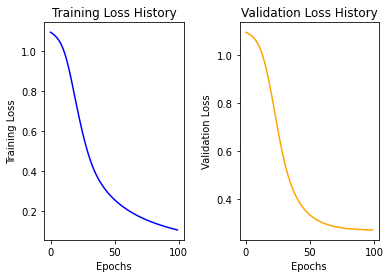

In [67]:
# plot training loss
plt.subplot(1, 2, 1)
plt.plot(loss_tr, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss History')

# plot validation loss
plt.subplot(1, 2, 2)
plt.plot(dev_loss, color='orange')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss History')

plt.subplots_adjust(wspace=0.4)
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [68]:
X_te= test_articles_ids
Y_te= test_label
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['pred']) 
            for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8533333333333334
Precision: 0.8558498866533634
Recall: 0.8533333333333334
F1-Score: 0.8532238631062531


/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [72]:
learning_rate = [0.001, 0.01]
Emb_size = [50, 200]
dropout_rates = [0.2, 0.4]
best_accuracy = 0.0
best_hyperparams = {}
para=[]
matrix=[]

for lr in learning_rate:
    for dim in Emb_size:
        for dr in dropout_rates:
            W = network_weights(vocab_size=len(vocab), 
                    embedding_dim=dim, 
                    hidden_dim=[], 
                    num_classes=3, 
                    init_val = 0.5)
            W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=lr, 
                            dropout=dr,
                            freeze_emb=False,
                            tolerance=0.01,
                            epochs=50)
            preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['pred']) for x,y in zip(X_te,Y_te)]
            Accuracy=accuracy_score(Y_te,preds_te)
            Precision=precision_score(Y_te,preds_te,average='macro')
            Recall=recall_score(Y_te,preds_te,average='macro')
            F1_Score=f1_score(Y_te,preds_te,average='macro')
            
            para.append([lr,dim,dr])
            matrix.append([Accuracy, Precision, Recall, F1_Score])

            if Accuracy > best_accuracy:
                best_accuracy = Accuracy
                best_hyperparams = {'learning_rate': lr, 'Emb_size': dim, 'dropout_rate': dr}


Epoch 1: train loss 1.0874, val loss 1.0899
Epoch 2: train loss 1.0703, val loss 1.0786
Epoch 3: train loss 1.0527, val loss 1.0670
Epoch 4: train loss 1.0341, val loss 1.0548
Epoch 5: train loss 1.0142, val loss 1.0417
Epoch 6: train loss 0.9927, val loss 1.0273
Epoch 7: train loss 0.9696, val loss 1.0117
Epoch 8: train loss 0.9450, val loss 0.9948
Epoch 9: train loss 0.9188, val loss 0.9765
Epoch 10: train loss 0.8913, val loss 0.9567
Epoch 11: train loss 0.8627, val loss 0.9355
Epoch 12: train loss 0.8331, val loss 0.9128
Epoch 13: train loss 0.8029, val loss 0.8885
Epoch 14: train loss 0.7725, val loss 0.8630
Epoch 15: train loss 0.7421, val loss 0.8364
Epoch 16: train loss 0.7120, val loss 0.8090
Epoch 17: train loss 0.6824, val loss 0.7809
Epoch 18: train loss 0.6538, val loss 0.7526
Epoch 19: train loss 0.6261, val loss 0.7240
Epoch 20: train loss 0.5996, val loss 0.6957
Epoch 21: train loss 0.5742, val loss 0.6680
Epoch 22: train loss 0.5503, val loss 0.6416
Epoch 23: train los

/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Epoch 1: train loss 1.0906, val loss 1.0921
Epoch 2: train loss 1.0766, val loss 1.0834
Epoch 3: train loss 1.0620, val loss 1.0742
Epoch 4: train loss 1.0466, val loss 1.0644
Epoch 5: train loss 1.0297, val loss 1.0536
Epoch 6: train loss 1.0110, val loss 1.0417
Epoch 7: train loss 0.9903, val loss 1.0285
Epoch 8: train loss 0.9674, val loss 1.0138
Epoch 9: train loss 0.9421, val loss 0.9973
Epoch 10: train loss 0.9146, val loss 0.9790
Epoch 11: train loss 0.8850, val loss 0.9587
Epoch 12: train loss 0.8540, val loss 0.9367
Epoch 13: train loss 0.8220, val loss 0.9129
Epoch 14: train loss 0.7895, val loss 0.8875
Epoch 15: train loss 0.7571, val loss 0.8606
Epoch 16: train loss 0.7251, val loss 0.8325
Epoch 17: train loss 0.6937, val loss 0.8034
Epoch 18: train loss 0.6632, val loss 0.7736
Epoch 19: train loss 0.6336, val loss 0.7433
Epoch 20: train loss 0.6055, val loss 0.7133
Epoch 21: train loss 0.5784, val loss 0.6836
Epoch 22: train loss 0.5522, val loss 0.6542
Epoch 23: train los

/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Epoch 1: train loss 1.0509, val loss 1.0716
Epoch 2: train loss 0.9923, val loss 1.0313
Epoch 3: train loss 0.9380, val loss 0.9932
Epoch 4: train loss 0.8869, val loss 0.9565
Epoch 5: train loss 0.8388, val loss 0.9209
Epoch 6: train loss 0.7935, val loss 0.8860
Epoch 7: train loss 0.7509, val loss 0.8519
Epoch 8: train loss 0.7108, val loss 0.8185
Epoch 9: train loss 0.6733, val loss 0.7862
Epoch 10: train loss 0.6384, val loss 0.7553
Epoch 11: train loss 0.6061, val loss 0.7258
Epoch 12: train loss 0.5758, val loss 0.6976
Epoch 13: train loss 0.5479, val loss 0.6710
Epoch 14: train loss 0.5223, val loss 0.6462
Epoch 15: train loss 0.4985, val loss 0.6230
Epoch 16: train loss 0.4765, val loss 0.6014
Epoch 17: train loss 0.4564, val loss 0.5815
Epoch 18: train loss 0.4378, val loss 0.5630
Epoch 19: train loss 0.4206, val loss 0.5462
Epoch 20: train loss 0.4047, val loss 0.5303
Epoch 21: train loss 0.3898, val loss 0.5157
Epoch 22: train loss 0.3762, val loss 0.5020
Epoch 23: train los

/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Epoch 1: train loss 1.0755, val loss 1.1224
Epoch 2: train loss 1.0126, val loss 1.0802
Epoch 3: train loss 0.9547, val loss 1.0402
Epoch 4: train loss 0.9000, val loss 1.0011
Epoch 5: train loss 0.8484, val loss 0.9628
Epoch 6: train loss 0.7991, val loss 0.9246
Epoch 7: train loss 0.7524, val loss 0.8869
Epoch 8: train loss 0.7080, val loss 0.8493
Epoch 9: train loss 0.6661, val loss 0.8120
Epoch 10: train loss 0.6270, val loss 0.7757
Epoch 11: train loss 0.5908, val loss 0.7406
Epoch 12: train loss 0.5572, val loss 0.7069
Epoch 13: train loss 0.5267, val loss 0.6751
Epoch 14: train loss 0.4983, val loss 0.6443
Epoch 15: train loss 0.4727, val loss 0.6159
Epoch 16: train loss 0.4497, val loss 0.5902
Epoch 17: train loss 0.4287, val loss 0.5660
Epoch 18: train loss 0.4100, val loss 0.5438
Epoch 19: train loss 0.3929, val loss 0.5239
Epoch 20: train loss 0.3771, val loss 0.5053
Epoch 21: train loss 0.3629, val loss 0.4885
Epoch 22: train loss 0.3498, val loss 0.4728
Epoch 23: train los

/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Epoch 1: train loss 0.8991, val loss 0.9717
Epoch 2: train loss 0.7116, val loss 0.7975
Epoch 3: train loss 0.5622, val loss 0.6079
Epoch 4: train loss 0.4384, val loss 0.4594
Epoch 5: train loss 0.3504, val loss 0.3718
Epoch 6: train loss 0.2889, val loss 0.3198
Epoch 7: train loss 0.2533, val loss 0.2946
Epoch 8: train loss 0.2217, val loss 0.2838
Epoch 9: train loss 0.1885, val loss 0.2640
Epoch 10: train loss 0.1601, val loss 0.2600
Epoch 11: train loss 0.1394, val loss 0.2526
Epoch 12: train loss 0.1241, val loss 0.2550
Epoch 13: train loss 0.1091, val loss 0.2600


/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Epoch 1: train loss 0.8681, val loss 0.9480
Epoch 2: train loss 0.6991, val loss 0.7700
Epoch 3: train loss 0.5540, val loss 0.5511
Epoch 4: train loss 0.4585, val loss 0.4197
Epoch 5: train loss 0.3931, val loss 0.3616
Epoch 6: train loss 0.3194, val loss 0.3026
Epoch 7: train loss 0.2792, val loss 0.2944
Epoch 8: train loss 0.2551, val loss 0.2919
Epoch 9: train loss 0.2195, val loss 0.2910


/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Epoch 1: train loss 0.8700, val loss 0.9600
Epoch 2: train loss 0.6302, val loss 0.7014
Epoch 3: train loss 0.4679, val loss 0.5188
Epoch 4: train loss 0.3612, val loss 0.4111
Epoch 5: train loss 0.2909, val loss 0.3500
Epoch 6: train loss 0.2371, val loss 0.3090
Epoch 7: train loss 0.1955, val loss 0.2832
Epoch 8: train loss 0.1681, val loss 0.2674
Epoch 9: train loss 0.1420, val loss 0.2565
Epoch 10: train loss 0.1212, val loss 0.2487
Epoch 11: train loss 0.1028, val loss 0.2439
Epoch 12: train loss 0.0879, val loss 0.2423
Epoch 13: train loss 0.0748, val loss 0.2453
Epoch 14: train loss 0.0661, val loss 0.2446
Epoch 15: train loss 0.0572, val loss 0.2438
Epoch 16: train loss 0.0495, val loss 0.2437
Epoch 17: train loss 0.0435, val loss 0.2484
Epoch 18: train loss 0.0374, val loss 0.2496


/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Epoch 1: train loss 0.8805, val loss 0.9556
Epoch 2: train loss 0.6711, val loss 0.7235
Epoch 3: train loss 0.4964, val loss 0.5124
Epoch 4: train loss 0.3888, val loss 0.4013
Epoch 5: train loss 0.3109, val loss 0.3320
Epoch 6: train loss 0.2601, val loss 0.3007
Epoch 7: train loss 0.2187, val loss 0.2835
Epoch 8: train loss 0.1742, val loss 0.2722
Epoch 9: train loss 0.1546, val loss 0.2720
Epoch 10: train loss 0.1313, val loss 0.2703
Epoch 11: train loss 0.1147, val loss 0.2697
Epoch 12: train loss 0.0958, val loss 0.2711
Epoch 13: train loss 0.0811, val loss 0.2732
Epoch 14: train loss 0.0659, val loss 0.2726


/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [73]:
para, matrix


([[0.001, 50, 0.2],
  [0.001, 50, 0.4],
  [0.001, 200, 0.2],
  [0.001, 200, 0.4],
  [0.01, 50, 0.2],
  [0.01, 50, 0.4],
  [0.01, 200, 0.2],
  [0.01, 200, 0.4]],
 [[0.8533333333333334,
   0.8542207908391483,
   0.8533333333333334,
   0.8528418803418804],
  [0.8555555555555555,
   0.8566716653964975,
   0.8555555555555555,
   0.8548395798030913],
  [0.8477777777777777,
   0.8488879105322186,
   0.8477777777777776,
   0.8472228283072066],
  [0.8466666666666667,
   0.8486429802446981,
   0.8466666666666667,
   0.846434888885462],
  [0.8488888888888889,
   0.8481046841232672,
   0.8488888888888888,
   0.8480658726361582],
  [0.85, 0.8499354879648039, 0.85, 0.8482053599993447],
  [0.8644444444444445,
   0.8650421030829346,
   0.8644444444444445,
   0.8642423243828703],
  [0.8588888888888889,
   0.8585518653376978,
   0.8588888888888889,
   0.8582687453253878]])

### Discuss how did you choose model hyperparameters ? 

Learning rate, Embedding size and dropout rates hyperparameters significantly affects the accuracy of a neural network. I'm performing a grid search above over the specified hyperparameter values and keeping track of the best performing set of hyperparameters based on the accuracy metric. 
I have started with a small learning rate i.e. 0.001 and gradually adjusting it based on the training progress and validation performance. Dropout is a technique to drop selected neurons at any time during training.
For learning rate : 0.001, Embedding size: 50,drop out rate: 0.4, the accuracy is: 0.8555555555555555 
which is the highest for 0.001 lr.
When the learning rate is 0.01, Embedding dimension is 200 and dropout rate is 0.2:
The Accuracy for this combination is highest amongst the other combinations.
For this model, accuracy is good when learning rate is low and embedding dimension is high.


# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [76]:
def get_glove_embeddings(f_zip, f_txt, word_to_id, emb_size=300):
    
    w_emb = np.zeros((len(word_to_id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word_to_id[word]] +=emb
    return w_emb

In [77]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word_to_id)
w_glove

array([[ 0.073143  ,  0.15172   , -0.17648999, ..., -0.57871997,
         0.27922001, -0.078284  ],
       [-0.14117   , -0.11568   , -0.57611001, ..., -0.18863   ,
         0.27243   ,  0.12526   ],
       [ 0.72355998, -0.20265   ,  0.39272001, ...,  0.016114  ,
        -0.23998   , -0.14477   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57735002,  0.53346997,  0.25926   , ..., -0.19133   ,
        -0.14083   ,  0.13174   ],
       [-0.13158   ,  0.11049   ,  0.64915001, ..., -0.17715999,
         0.26337999, -0.38286   ]])

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [78]:
# Initialise the weights of network 
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3, init_val = 0.1)

#Replace the weights of the embedding matrix with w_glove
W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr,Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,lr=0.001,
                                       dropout = 0.2,freeze_emb = True,tolerance=0.01,epochs=100)

Shape W0 (2000, 300)
Shape W1 (300, 3)
Epoch 1: train loss 1.4074, val loss 1.4718
Epoch 2: train loss 1.3591, val loss 1.4383
Epoch 3: train loss 1.2380, val loss 1.3186
Epoch 4: train loss 1.1478, val loss 1.2290
Epoch 5: train loss 1.0629, val loss 1.1424
Epoch 6: train loss 0.9908, val loss 1.0675
Epoch 7: train loss 0.9185, val loss 0.9895
Epoch 8: train loss 0.8777, val loss 0.9467
Epoch 9: train loss 0.8229, val loss 0.8855
Epoch 10: train loss 0.7810, val loss 0.8386
Epoch 11: train loss 0.7506, val loss 0.8043
Epoch 12: train loss 0.7308, val loss 0.7819
Epoch 13: train loss 0.6925, val loss 0.7366
Epoch 14: train loss 0.6674, val loss 0.7065
Epoch 15: train loss 0.6431, val loss 0.6772
Epoch 16: train loss 0.6253, val loss 0.6553
Epoch 17: train loss 0.6076, val loss 0.6338
Epoch 18: train loss 0.6061, val loss 0.6317
Epoch 19: train loss 0.5882, val loss 0.6096
Epoch 20: train loss 0.5702, val loss 0.5868
Epoch 21: train loss 0.5628, val loss 0.5771
Epoch 22: train loss 0.56

In [80]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['pred']) 
            for x,y in zip(X_te,Y_te)]

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8844444444444445
Precision: 0.8856056418245473
Recall: 0.8844444444444445
F1-Score: 0.8831928424546054


/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


### Discuss how did you choose model hyperparameters ? 

In [81]:
learning_rate = [0.001, 0.01]
Emb_size = [50, 200]
dropout_rates = [0.2, 0.4]
best_accuracy = 0.0
best_hyperparams = {}
para=[]
matrix=[]

for lr in learning_rate:
    for dim in Emb_size:
        for dr in dropout_rates:
            W = network_weights(vocab_size=len(vocab), 
                    embedding_dim=dim, 
                    hidden_dim=[], 
                    num_classes=3, 
                    init_val = 0.5)
            W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=lr, 
                            dropout=dr,
                            freeze_emb=False,
                            tolerance=0.01,
                            epochs=50)
            preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['pred']) for x,y in zip(X_te,Y_te)]
            Accuracy=accuracy_score(Y_te,preds_te)
            Precision=precision_score(Y_te,preds_te,average='macro')
            Recall=recall_score(Y_te,preds_te,average='macro')
            F1_Score=f1_score(Y_te,preds_te,average='macro')
            
            para.append([lr,dim,dr])
            matrix.append([Accuracy, Precision, Recall, F1_Score])

            if Accuracy > best_accuracy:
                best_accuracy = Accuracy
                best_hyperparams = {'learning_rate': lr, 'Emb_size': dim, 'dropout_rate': dr}

Epoch 1: train loss 1.0857, val loss 1.0995
Epoch 2: train loss 1.0660, val loss 1.0880
Epoch 3: train loss 1.0456, val loss 1.0763
Epoch 4: train loss 1.0240, val loss 1.0638
Epoch 5: train loss 1.0011, val loss 1.0504
Epoch 6: train loss 0.9767, val loss 1.0358
Epoch 7: train loss 0.9506, val loss 1.0200
Epoch 8: train loss 0.9231, val loss 1.0028
Epoch 9: train loss 0.8943, val loss 0.9841
Epoch 10: train loss 0.8647, val loss 0.9639
Epoch 11: train loss 0.8343, val loss 0.9421
Epoch 12: train loss 0.8039, val loss 0.9192
Epoch 13: train loss 0.7737, val loss 0.8951
Epoch 14: train loss 0.7437, val loss 0.8698
Epoch 15: train loss 0.7142, val loss 0.8437
Epoch 16: train loss 0.6856, val loss 0.8171
Epoch 17: train loss 0.6580, val loss 0.7904
Epoch 18: train loss 0.6311, val loss 0.7637
Epoch 19: train loss 0.6053, val loss 0.7373
Epoch 20: train loss 0.5804, val loss 0.7112
Epoch 21: train loss 0.5568, val loss 0.6859
Epoch 22: train loss 0.5345, val loss 0.6614
Epoch 23: train los

/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Epoch 1: train loss 1.0901, val loss 1.1036
Epoch 2: train loss 1.0725, val loss 1.0923
Epoch 3: train loss 1.0544, val loss 1.0807
Epoch 4: train loss 1.0349, val loss 1.0683
Epoch 5: train loss 1.0138, val loss 1.0550
Epoch 6: train loss 0.9903, val loss 1.0402
Epoch 7: train loss 0.9643, val loss 1.0237
Epoch 8: train loss 0.9359, val loss 1.0051
Epoch 9: train loss 0.9050, val loss 0.9843
Epoch 10: train loss 0.8721, val loss 0.9612
Epoch 11: train loss 0.8381, val loss 0.9358
Epoch 12: train loss 0.8037, val loss 0.9085
Epoch 13: train loss 0.7695, val loss 0.8795
Epoch 14: train loss 0.7364, val loss 0.8496
Epoch 15: train loss 0.7049, val loss 0.8188
Epoch 16: train loss 0.6747, val loss 0.7877
Epoch 17: train loss 0.6461, val loss 0.7564
Epoch 18: train loss 0.6188, val loss 0.7251
Epoch 19: train loss 0.5926, val loss 0.6940
Epoch 20: train loss 0.5673, val loss 0.6631
Epoch 21: train loss 0.5430, val loss 0.6333
Epoch 22: train loss 0.5197, val loss 0.6046
Epoch 23: train los

/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Epoch 1: train loss 1.0432, val loss 1.0767
Epoch 2: train loss 0.9859, val loss 1.0378
Epoch 3: train loss 0.9329, val loss 1.0011
Epoch 4: train loss 0.8833, val loss 0.9656
Epoch 5: train loss 0.8366, val loss 0.9316
Epoch 6: train loss 0.7924, val loss 0.8984
Epoch 7: train loss 0.7507, val loss 0.8662
Epoch 8: train loss 0.7116, val loss 0.8348
Epoch 9: train loss 0.6748, val loss 0.8044
Epoch 10: train loss 0.6402, val loss 0.7748
Epoch 11: train loss 0.6079, val loss 0.7464
Epoch 12: train loss 0.5779, val loss 0.7193
Epoch 13: train loss 0.5500, val loss 0.6934
Epoch 14: train loss 0.5241, val loss 0.6688
Epoch 15: train loss 0.5003, val loss 0.6457
Epoch 16: train loss 0.4784, val loss 0.6240
Epoch 17: train loss 0.4583, val loss 0.6039
Epoch 18: train loss 0.4396, val loss 0.5849
Epoch 19: train loss 0.4221, val loss 0.5672
Epoch 20: train loss 0.4060, val loss 0.5508
Epoch 21: train loss 0.3910, val loss 0.5355
Epoch 22: train loss 0.3772, val loss 0.5213
Epoch 23: train los

/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Epoch 1: train loss 1.0334, val loss 1.0649
Epoch 2: train loss 0.9701, val loss 1.0237
Epoch 3: train loss 0.9122, val loss 0.9843
Epoch 4: train loss 0.8575, val loss 0.9458
Epoch 5: train loss 0.8060, val loss 0.9078
Epoch 6: train loss 0.7577, val loss 0.8703
Epoch 7: train loss 0.7122, val loss 0.8329
Epoch 8: train loss 0.6698, val loss 0.7960
Epoch 9: train loss 0.6306, val loss 0.7597
Epoch 10: train loss 0.5944, val loss 0.7245
Epoch 11: train loss 0.5612, val loss 0.6906
Epoch 12: train loss 0.5305, val loss 0.6577
Epoch 13: train loss 0.5027, val loss 0.6266
Epoch 14: train loss 0.4775, val loss 0.5974
Epoch 15: train loss 0.4545, val loss 0.5701
Epoch 16: train loss 0.4335, val loss 0.5444
Epoch 17: train loss 0.4146, val loss 0.5211
Epoch 18: train loss 0.3971, val loss 0.4992
Epoch 19: train loss 0.3814, val loss 0.4795
Epoch 20: train loss 0.3672, val loss 0.4617
Epoch 21: train loss 0.3544, val loss 0.4453
Epoch 22: train loss 0.3423, val loss 0.4299
Epoch 23: train los

/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Epoch 1: train loss 0.8959, val loss 0.9544
Epoch 2: train loss 0.6711, val loss 0.7457
Epoch 3: train loss 0.5135, val loss 0.5499
Epoch 4: train loss 0.4021, val loss 0.4225
Epoch 5: train loss 0.3277, val loss 0.3531
Epoch 6: train loss 0.2756, val loss 0.3163
Epoch 7: train loss 0.2356, val loss 0.2985
Epoch 8: train loss 0.2019, val loss 0.2795
Epoch 9: train loss 0.1770, val loss 0.2775
Epoch 10: train loss 0.1592, val loss 0.2870


/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Epoch 1: train loss 0.8989, val loss 0.9564
Epoch 2: train loss 0.7134, val loss 0.7874
Epoch 3: train loss 0.5786, val loss 0.5774
Epoch 4: train loss 0.4836, val loss 0.4421
Epoch 5: train loss 0.3980, val loss 0.3439
Epoch 6: train loss 0.3471, val loss 0.3088
Epoch 7: train loss 0.3052, val loss 0.3020
Epoch 8: train loss 0.2681, val loss 0.2885
Epoch 9: train loss 0.2415, val loss 0.2941
Epoch 10: train loss 0.2264, val loss 0.2956


/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Epoch 1: train loss 0.8782, val loss 0.9514
Epoch 2: train loss 0.6429, val loss 0.6999
Epoch 3: train loss 0.4797, val loss 0.5187
Epoch 4: train loss 0.3718, val loss 0.4113
Epoch 5: train loss 0.2996, val loss 0.3485
Epoch 6: train loss 0.2450, val loss 0.3100
Epoch 7: train loss 0.2065, val loss 0.2900
Epoch 8: train loss 0.1714, val loss 0.2736
Epoch 9: train loss 0.1470, val loss 0.2653
Epoch 10: train loss 0.1256, val loss 0.2601
Epoch 11: train loss 0.1045, val loss 0.2562
Epoch 12: train loss 0.0896, val loss 0.2588
Epoch 13: train loss 0.0766, val loss 0.2587
Epoch 14: train loss 0.0683, val loss 0.2595
Epoch 15: train loss 0.0597, val loss 0.2633
Epoch 16: train loss 0.0506, val loss 0.2637


/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Epoch 1: train loss 0.8495, val loss 0.9374
Epoch 2: train loss 0.6609, val loss 0.7097
Epoch 3: train loss 0.4953, val loss 0.5103
Epoch 4: train loss 0.3873, val loss 0.4000
Epoch 5: train loss 0.3139, val loss 0.3453
Epoch 6: train loss 0.2636, val loss 0.3168
Epoch 7: train loss 0.2170, val loss 0.2945
Epoch 8: train loss 0.1841, val loss 0.2854
Epoch 9: train loss 0.1548, val loss 0.2803
Epoch 10: train loss 0.1355, val loss 0.2821


/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abolivi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [82]:
para, matrix

([[0.001, 50, 0.2],
  [0.001, 50, 0.4],
  [0.001, 200, 0.2],
  [0.001, 200, 0.4],
  [0.01, 50, 0.2],
  [0.01, 50, 0.4],
  [0.01, 200, 0.2],
  [0.01, 200, 0.4]],
 [[0.8522222222222222,
   0.8537529050571,
   0.8522222222222222,
   0.8515323721262419],
  [0.8466666666666667,
   0.8472423295359075,
   0.8466666666666667,
   0.8457826264852994],
  [0.8511111111111112,
   0.8523271627491577,
   0.851111111111111,
   0.8506419031712719],
  [0.8455555555555555,
   0.8460720798246153,
   0.8455555555555555,
   0.8449821468766249],
  [0.8544444444444445,
   0.8536851092896175,
   0.8544444444444445,
   0.8532255359923345],
  [0.8466666666666667,
   0.8476592696982502,
   0.8466666666666667,
   0.8450911260511101],
  [0.8577777777777778,
   0.8577608483833213,
   0.8577777777777778,
   0.8575287961098113],
  [0.8566666666666667,
   0.8559066653961599,
   0.8566666666666668,
   0.8555783285910454]])

I'm trying for different combinations of lr, dr, and emb dim. When lr is 0.01, emb dim is 200 and dr is 0.2, the model performs well. Accuracy is much better compared to the other combinations.

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [98]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[300],num_classes=3, init_val = 0.1)
W[0] = w_glove
    
W, loss_tr, dev_loss = SGD(X_tr,Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,lr= 0.001,dropout=0.2,freeze_emb=False,print_progress=True,
tolerance=0.001,epochs=5)

Epoch 1: train loss 1.2506, val loss 1.2728


In [ ]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['pred']) 
            for x,y in zip(X_te,Y_te)]

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

### Discuss how did you choose model hyperparameters ? 

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |0.8558498866533634|0.8533333333333334|0.8532238631062531|0.8533333333333334|
| Average Embedding (Pre-trained)  |0.8856056418245473|0.8844444444444445|0.8831928424546054|0.8844444444444445|
| Average Embedding (Pre-trained) + X hidden layers    |   |   |   |   |


Please discuss why your best performing model is better than the rest and provide a bried error analaysis.

In [ ]:
Average Embedding (Pre-trained) model is performing better in my case. To train and evaluate a network with a deeper 
architecture, I have already added a loop in a backward_pass function for the hidden layer. As we increase the number 
of hidden layers, the network has the potential to learn more complex representations of the data. 
Deeper architectures can capture intricate patterns and hierarchies in the data, allowing the model to achieve 
higher performance.